In [15]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import ttest_ind
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS


# read files
df_2009 = pd.read_csv('red_sox_2009.csv')
df_2010 = pd.read_csv('red_sox_2010.csv')
df_2011 = pd.read_csv('red_sox_2011.csv')
df_2012 = pd.read_csv('red_sox_2012.csv')

# add a year column
df_2009['year'] = 2009
df_2010['year'] = 2010
df_2011['year'] = 2011
df_2012['year'] = 2012

# define seat groups
closest = ['DUGOUTBOX', 'FieldBox', 'RFFieldBox', 'RFROOFBOX', 'PAVBOX', 'PAVCLB_HP', 'LogeBox', 'MONSTR']
mid_prem = ['EMCCLUB', 'PAVCLUB', 'LFPAV', 'RFDECK_TABLE']
mid_std = ['LowerBleachers', 'MONSTR_SRO', 'IFGS', 'RFGS']
upper = ['FamilyGS', 'UpperBleachers', 'RFDECK_SRO']
farthest = ['PAVSRO', 'SRO']

def categorize_seat_type(sectiontype):
    if sectiontype in closest:
        return 'closest'
    elif sectiontype in mid_prem:
        return 'mid_prem'
    elif sectiontype in mid_std:
        return 'mid_std'
    elif sectiontype in upper:
        return 'upper'
    elif sectiontype in farthest:
        return 'farthest'


def apply_seat_type(df):
    # create column with seat type
    df['seat_type_group'] = df['sectiontype'].apply(categorize_seat_type)
    df['closest'] = df['sectiontype'].isin(closest).astype(int)
    df['mid_prem'] = df['sectiontype'].isin(mid_prem).astype(int)
    df['mid_std'] = df['sectiontype'].isin(mid_std).astype(int)
    df['upper'] = df['sectiontype'].isin(upper).astype(int)
    df['farthest'] = df['sectiontype'].isin(farthest).astype(int)

apply_seat_type(df_2009)
apply_seat_type(df_2010)
apply_seat_type(df_2011)
apply_seat_type(df_2012)

# define whether it's a popular rival
rival = ['NYY', 'BAL', 'TB']

df_2009['rival'] = df_2009['team'].isin(rival).astype(int)
df_2010['rival'] = df_2010['team'].isin(rival).astype(int)
df_2011['rival'] = df_2011['team'].isin(rival).astype(int)
df_2012['rival'] = df_2012['team'].isin(rival).astype(int)



# create dataframe with all years
full_df = pd.concat([df_2009, df_2010, df_2011, df_2012])

# t_stat, p_value = ttest_ind(df_2009['price_per_ticket'], 
#                             df_2010['price_per_ticket'])

# # t-test to check differences between prices in each year
# for year in full_df['year'].unique():
#     df_year = full_df[full_df['year'] == year]
#     stat, p_value = ttest_ind(df_year['price_per_ticket'], full_df['price_per_ticket'])
#     print(f"t-test result for year {year}: p-value = {p_value}")


In [16]:
def plot_price(df1, year):
    # plot y = days_from_transaction_until_game, x = price_per_ticket
    dftug = 'days_from_transaction_until_game'
    ppt = 'price_per_ticket'
    
    # define colors for seat type group
    colors = {
        'closest': 'blue',
        'mid_prem': 'green',
        'mid_std': 'orange',
        'upper': 'purple',
        'farthest': 'red'
    }
    plt.figure(figsize=(10, 6))

    # plot each group in different color
    for group, color in colors.items():
        subset = df1[df1['seat_type_group'] == group]
        plt.scatter(subset[dftug], subset[ppt], label=group, color=color)
    
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.title(year + ' Price change as game approaches by Section Group')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Section Group')
    plt.tight_layout()
    plt.show()
    # plt.scatter(df1[dftug], df1[ppt],
    #         label='% Price change as game approaches', color='lightblue', linestyle='-')

def plot_log_price(df1, year):
    # plot y = days_from_transaction_until_game, x = price_per_ticket
    dftug = 'days_from_transaction_until_game'
    
    # define colors for seat type group
    colors = {
        'closest': 'blue',
        'mid_prem': 'green',
        'mid_std': 'orange',
        'upper': 'purple',
        'farthest': 'red'
    }
    plt.figure(figsize=(10, 6))

    # plot each group in different color
    for group, color in colors.items():
        subset = df1[df1['seat_type_group'] == group]
        plt.scatter(subset[dftug], subset['logprice'], label=group, color=color)
    
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.title(year + ' % Price change as game approaches by Section Group')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Section Group')
    plt.tight_layout()
    plt.show()
    # plt.scatter(df1[dftug], df1[ppt],
    #         label='% Price change as game approaches', color='lightblue', linestyle='-')

def plot_line(df, year):
    # plot y = price_per_ticket, x = days_from_transaction_until_game
    dftug = 'days_from_transaction_until_game'
    ppt = 'price_per_ticket'
    
    # define colors for seat type group
    colors = {
        'closest': 'blue',
        'mid_prem': 'green',
        'mid_std': 'orange',
        'upper': 'purple',
        'farthest': 'red'
    }

    plt.figure(figsize=(10, 6))



    # Fit and plot regression lines for each group
    for group, color in colors.items():
        subset = df[df['seat_type_group'] == group]
        z = np.polyfit(subset[dftug], subset[ppt], 1)
        p = np.poly1d(z)
        plt.plot(subset[dftug], p(subset[dftug]), color=color, label=f'{group} trend')

    plt.xlabel('Days from Transaction Until Game')
    plt.ylabel('Price ($)')
    plt.title(year + ' Price Change as Game Approaches by Section Group')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Seat Type Group')
    plt.tight_layout()
    plt.show()

# plot_price(df_2009, '2009')
# plot_price(df_2010, '2010')
# plot_price(df_2011, '2011')
# plot_price(df_2012, '2012')

# plot_log_price(df_2009, '2009')
# plot_log_price(df_2010, '2010')
# plot_log_price(df_2011, '2011')
# plot_log_price(df_2012, '2012')

# plot_line(df_2009, '2009')
# plot_line(df_2010, '2010')
# plot_line(df_2011, '2011')
# plot_line(df_2012, '2012')


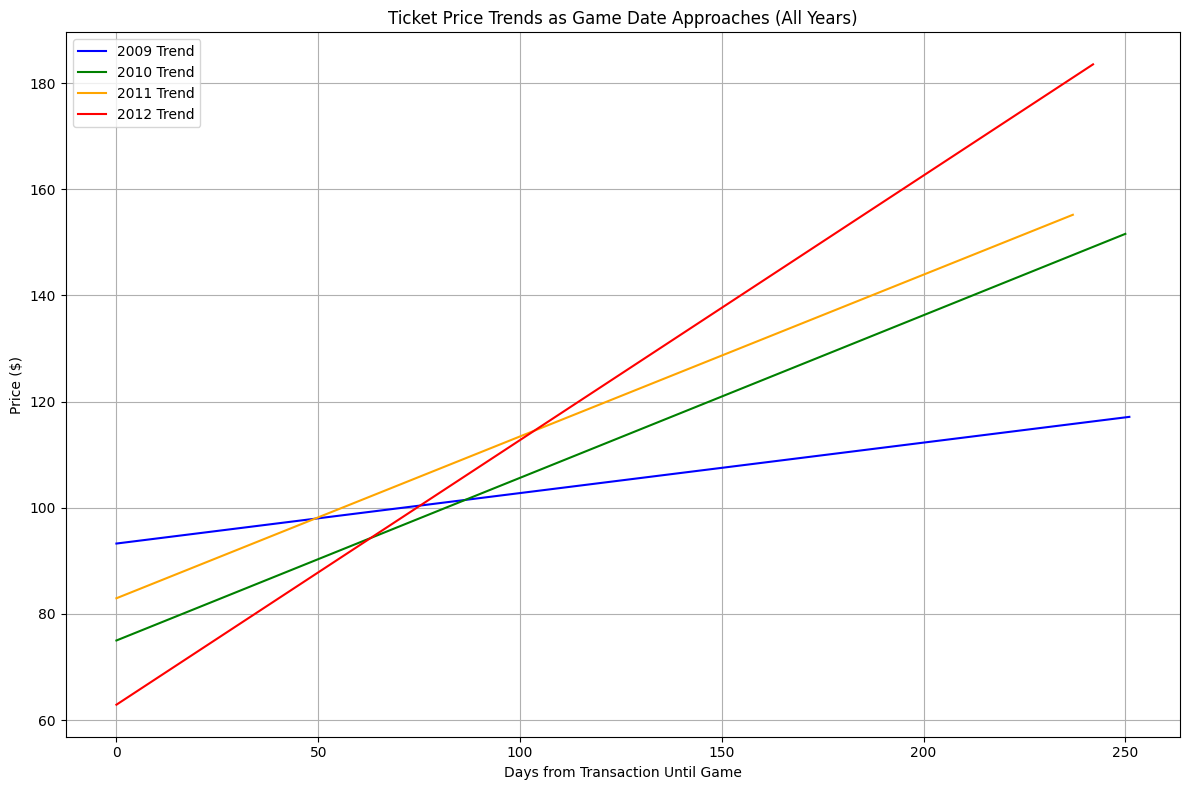

In [17]:
def plot_all_years(full_df):
    colors = {
        2009: 'blue',
        2010: 'green',
        2011: 'orange',
        2012: 'red'
    }

    plt.figure(figsize=(12, 8))

    for year, color in colors.items():
        subset = full_df[full_df['year'] == year]
        #plt.scatter(subset['days_from_transaction_until_game'], subset['price_per_ticket'], 
        #            color=color, alpha=0.5, label=f'{year} Data')
        
        z = np.polyfit(subset['days_from_transaction_until_game'], subset['price_per_ticket'], 1)
        p = np.poly1d(z)
        plt.plot(subset['days_from_transaction_until_game'].sort_values(), 
                 p(subset['days_from_transaction_until_game'].sort_values()), color=color, 
                 label=f'{year} Trend')

    plt.xlabel('Days from Transaction Until Game')
    plt.ylabel('Price ($)')
    plt.title('Ticket Price Trends as Game Date Approaches (All Years)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_all_years(full_df)

# set year as the index
full_df = full_df.set_index(['year', full_df.index])


In [18]:
# regression (cross-sectional data)
# try regressions for each year to see difference
model_09 = smf.ols(
    formula='price_per_ticket ~ days_from_transaction_until_game + mid_prem + mid_std + farthest + upper + weekend_game + day_game + rival', 
    data=df_2009
)
result_09 = model_09.fit()
# print(result_09.summary())

model_10 = smf.ols(
    formula='price_per_ticket ~ days_from_transaction_until_game + mid_prem + mid_std + farthest + upper + weekend_game + day_game + rival', 
    data=df_2010
)
result_10 = model_10.fit()
print(result_10.summary())

model_11 = smf.ols(
    formula='price_per_ticket ~ days_from_transaction_until_game + mid_prem + mid_std + farthest + upper + weekend_game + day_game + rival', 
    data=df_2011
)
result_11 = model_11.fit()
# print(result_11.summary())

model_12 = smf.ols(
    formula='price_per_ticket ~ days_from_transaction_until_game + mid_prem + mid_std + farthest + upper + weekend_game + day_game + rival', 
    data=df_2012
)
result_12 = model_12.fit()
# print(result_12.summary())

                            OLS Regression Results                            
Dep. Variable:       price_per_ticket   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     8543.
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:27:00   Log-Likelihood:            -6.5337e+05
No. Observations:              118775   AIC:                         1.307e+06
Df Residuals:                  118766   BIC:                         1.307e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [19]:
full_df = full_df.reset_index()

full_df = pd.get_dummies(full_df, columns=['year'], drop_first=True)

formula = 'price_per_ticket ~ days_from_transaction_until_game + year_2010 + year_2011 + year_2012 + mid_prem + mid_std + farthest + upper + weekend_game + day_game + rival'

# Fit the OLS model with year fixed effects
model_full = smf.ols(formula=formula, data=full_df)
result_full = model_full.fit()
print(result_full.summary())

formula_log = 'logprice ~ days_from_transaction_until_game + year_2010 + year_2011 + year_2012 + mid_prem + mid_std + farthest + upper + weekend_game + day_game + rival'
# Fit the OLS model with year fixed effects
model_full_log = smf.ols(formula=formula_log, data=full_df)
result_full_log = model_full_log.fit()
print(result_full_log.summary())

# model_full = PanelOLS.from_formula(
#     'price_per_ticket ~ days_from_transaction_until_game + mid_prem + mid_std + farthest + upper + weekend_game + day_game + EntityEffects',
#     data=full_df
# )
# result_full = model_full.fit(cov_type='clustered', cluster_entity=True)
# print(result_full.summary)



                            OLS Regression Results                            
Dep. Variable:       price_per_ticket   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                 2.048e+04
Date:                Fri, 25 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:27:01   Log-Likelihood:            -2.5388e+06
No. Observations:              452935   AIC:                         5.078e+06
Df Residuals:                  452923   BIC:                         5.078e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [20]:
# model_full_log = PanelOLS.from_formula(
#     'logprice ~ days_from_transaction_until_game + mid_prem + mid_std + farthest + upper + weekend_game + day_game + EntityEffects',
#     data=full_df
# )
# result_full_log = model_full_log.fit(cov_type='clustered', cluster_entity=True)
# print(result_full_log.summary)


In [21]:
# full_df = full_df.reset_index()

# model_full = PanelOLS.from_formula(
#     'price_per_ticket ~ days_from_transaction_until_game * C(year) + mid_prem + mid_std + farthest + upper + weekend_game + day_game',
#     data=full_df
# )
# result_full = model_full.fit(cov_type='clustered', cluster_entity=True)
# print(result_full.summary)
